# 06 - Trees

https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/06-trees/homework.md

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import re
from tqdm.auto import tqdm

In [3]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [4]:
import xgboost as xgb

/home/user/miniconda/envs/mlzoomcamp-ubuntu/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
PATH = "./data/housing.csv.zip"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
print(df.shape)
df.total_bedrooms = df.total_bedrooms.fillna(0)
df.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
# Apply the log transform to median_house_value.
df['median_house_value'] = np.log(df['median_house_value'])

In [7]:
# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1.
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=len(df_test), random_state=1)
df_train.shape, df_val.shape, df_test.shape

((12384, 10), (4128, 10), (4128, 10))

In [8]:
y_train = df_train.pop('median_house_value').values
y_val = df_val.pop('median_house_value').values
y_test = df_test.pop('median_house_value').values

- We will use `DictVectorizer` to turn train and validation into matrices.

In [9]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_train.shape, X_val.shape

((12384, 13), (4128, 13))

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



Which feature is used for splitting the data?

Answer: __ocean_proximity=INLAND__

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [12]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

0.2453508692239376

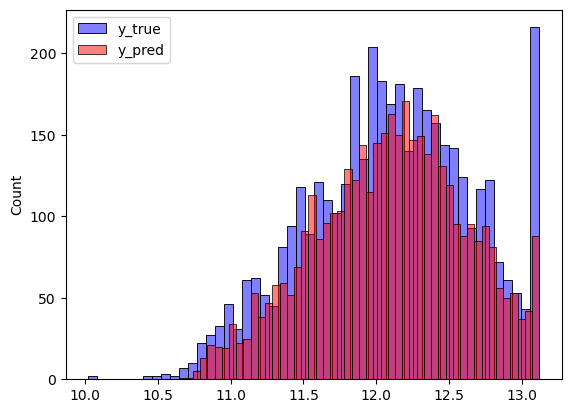

In [13]:
sns.histplot(y_val, label='y_true', color='b', alpha=0.5, bins=50)
sns.histplot(y_pred, label='y_pred', color='r', alpha=0.5, bins=50)
plt.legend();

In [14]:
round(rmse, 2)

0.25

What's the RMSE of this model on validation?

Answer: __0.25__

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

  0%|          | 0/20 [00:00<?, ?it/s]

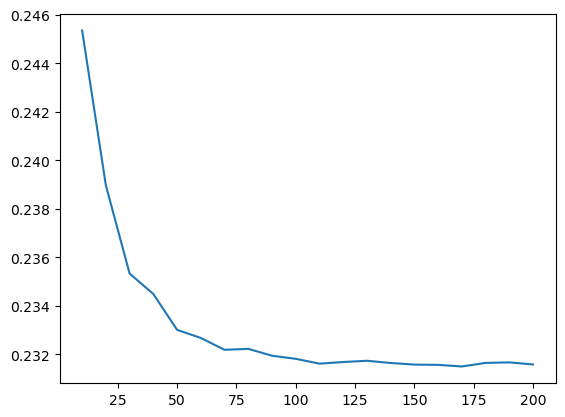

In [15]:
scores = []
estimators = range(10,201,10) 
for n in tqdm(estimators):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    scores.append(rmse)
plt.plot(estimators, scores) 

After which value of `n_estimators` does RMSE stop improving?

Answer: __150__

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

  0%|          | 0/4 [00:00<?, ?it/s]

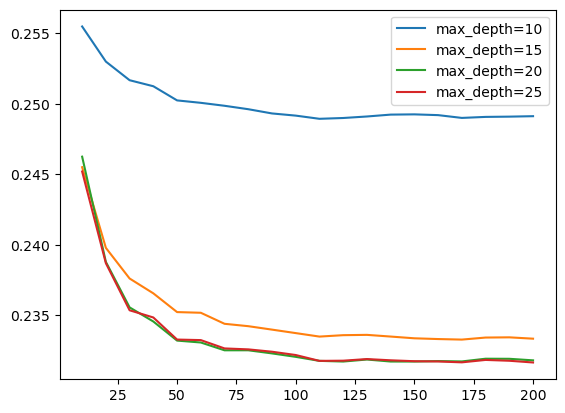

In [16]:
full_scores = []
for d in tqdm([10, 15, 20, 25]):
    scores = []
    estimators = range(10,201,10) 
    for n in estimators: 
        rf = RandomForestRegressor(max_depth=d, n_estimators=n, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        scores.append(rmse)
        full_scores.append([d, n, rmse])
    plt.plot(estimators, scores, label=f'max_depth={d}') 
plt.legend();

In [17]:
df_scores = pd.DataFrame(full_scores, columns=['max_depth', 'n_estimators', 'rmse'])
df_scores.iloc[df_scores['rmse'].argmin()]

max_depth        25.000000
n_estimators    200.000000
rmse              0.231666
Name: 79, dtype: float64

What's the best `max_depth`:

Answer: __25__

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [18]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

pd.DataFrame({'feature':dv.feature_names_, 'feature_importances': rf.feature_importances_}) \
        .sort_values('feature_importances', ascending = False) \
        .head()

,feature,feature_importances
4,median_income,0.363890
6,ocean_proximity=INLAND,0.310901
2,latitude,0.100636
3,longitude,0.096872
1,housing_median_age,0.032923


What's the most important feature?

Answer: __median_income__

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [19]:
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [20]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [21]:
watch_list = [(dtrain, 'train'), (dval, 'validation')]

0it [00:00, ?it/s]

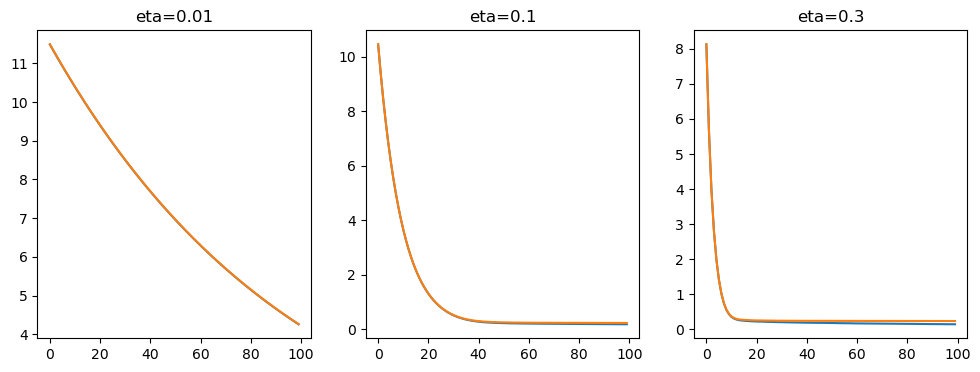

In [22]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
scores = []
for i, eta in tqdm(enumerate([0.01, 0.1, 0.3])):
    xgb_params['eta'] = eta
    results={}
    xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100,
              evals=watch_list, evals_result=results, verbose_eval=False)
    
    axes[i].set_title(f'eta={eta}')
    axes[i].plot(results['train']['rmse'], label='train',)
    axes[i].plot(results['validation']['rmse'], label='validation')
    
    scores.append([eta, np.min(results['validation']['rmse'])])

- Now, change eta first to 0.1 and then to 0.01.

In [23]:
pd.DataFrame(scores, columns=['eta', 'rmse'])

,eta,rmse
0,0.01,4.264994
1,0.10,0.232453
2,0.30,0.227837


Which eta leads to the best RMSE score on the validation dataset?

Answer: __0.30__